In [88]:
import pandas as pd
from pandas import to_datetime
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric

In [135]:
#prepare the data

df=pd.read_csv('data/multivariate/ken_u5_he - Sheet1.csv')
xlabel = 'Year'
y1label = 'Heath Expenditure (%GDP)' 
y2label = 'Under 5 Mortality'
title = 'Health Expenditure vs Under 5 Mortality Rate'
df.head(10)

,ds,y,he
0,2000-12-31,98.5,4.639261
1,2001-12-31,94.2,4.803683
2,2002-12-31,89.9,4.958624
3,2003-12-31,85.5,5.169111
4,2004-12-31,81.1,5.344938
5,2005-12-31,76.5,5.314368
6,2006-12-31,72.3,5.873446
7,2007-12-31,68.3,5.997070
8,2008-12-31,63.9,6.049857
9,2009-12-31,60.3,6.027808


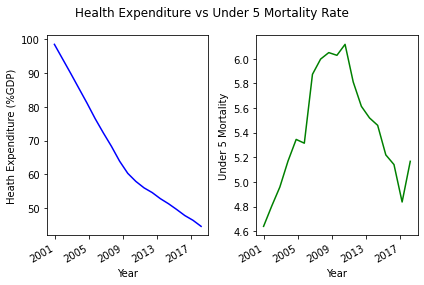

In [136]:
#visualize csv data
df['ds']= to_datetime(df['ds'])

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(df['ds'],df['y'], color = 'blue')
ax2.plot(df['ds'],df['he'], color = 'green')
ax1.set(xlabel = xlabel,ylabel = y1label)
ax2.set(xlabel = xlabel,ylabel = y2label)

#transform the ticks (dates) ----- picked directly from matplotlib
# Major ticks every 6 months.
fmt_year = mdates.MonthLocator(interval = 50)
ax1.xaxis.set_major_locator(fmt_year)
ax2.xaxis.set_major_locator(fmt_year)

# Text in the x axis will be displayed in 'YYYY' format.
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Rotates and right aligns the x labels, and moves the bottom of the axes up to make room for them.
fig.autofmt_xdate()
fig.suptitle(title)
fig.tight_layout()

In [79]:
#convert the dates to a datetimestring
#separate data into training and test datasets as arrays
training_set = df.loc[:13]
training_set['ds']= to_datetime(training_set['ds'])
test_set = df.loc[13:]
test_set['ds']= to_datetime(test_set['ds'])
test_years=df.loc[13:, 'ds']


<ipython-input-79-390e7df78660>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  training_set['ds']= to_datetime(training_set['ds'])
<ipython-input-79-390e7df78660>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set['ds']= to_datetime(test_set['ds'])


In [80]:
#define and fit the model
m= Prophet()
m.add_regressor('he')
m.fit(training_set)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 10.


INFO:prophet:Making 2 forecasts with cutoffs between 2010-01-01 00:00:00 and 2012-12-31 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:prophet:n_changepoints greater than number of observations. Using 7.
INFO:prophet:n_changepoints greater than number of observations. Using 9.


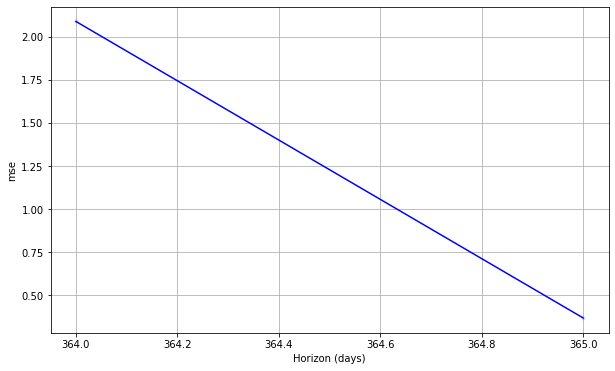

In [85]:
#check model perfomance using cross validation
#not sure how this works with little data

#create a custom cutoff date
df_cv = cross_validation(m, initial='2555 days', period='1095 days', horizon = '365 days')

df_p = performance_metrics(df_cv)
df_p.head()

fig = plot_cross_validation_metric(df_cv, metric='mse')


In [86]:
#predict

#prepare the future dates
future = m.make_future_dataframe(freq = 'Y', periods=10)
forecast = m.predict(test_set)
forecast[['ds','yhat']].tail()

,ds,yhat
1,2014-12-31,51.026120
2,2015-12-31,49.162758
3,2016-12-31,47.830033
4,2017-12-31,45.912038
5,2018-12-31,44.357887


In [27]:
df.iloc[:5, 2:3]

,he
0,4.639261
1,4.803683
2,4.958624
3,5.169111
4,5.344938


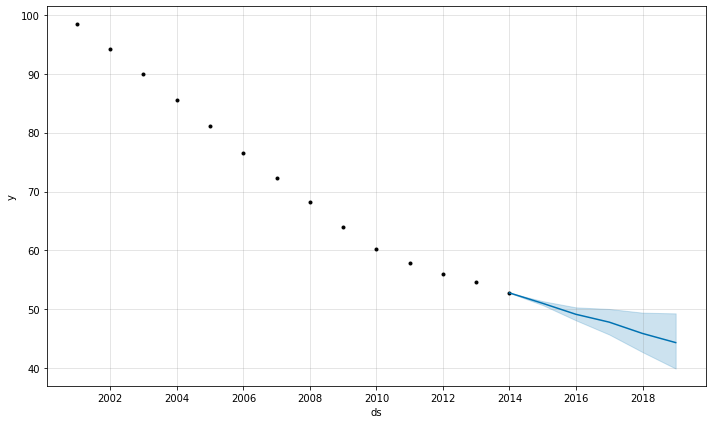

In [122]:
#visualize
predicted = m.plot(forecast)

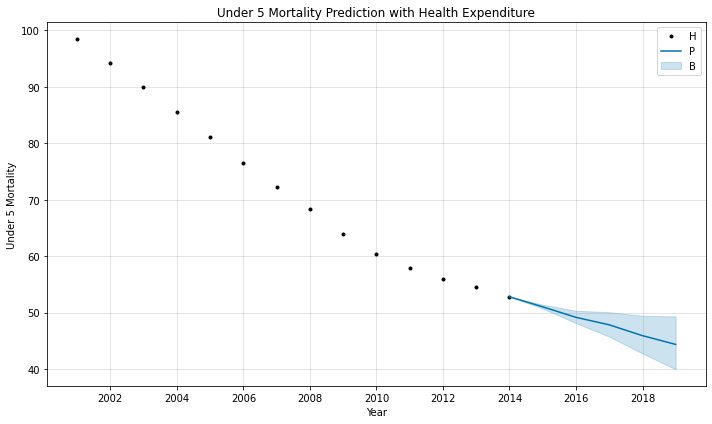

In [133]:
# Customize the forecast plot to include relevant labels  --- adapted from Bartosz Mikulski
fig = plt.figure(facecolor='w', figsize=(10, 6))
ax = fig.add_subplot(111)
fcst_t = forecast['ds'].dt.to_pydatetime()
ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.')
ax.plot(fcst_t, forecast['yhat'], ls='-', c='#0072B2')
ax.fill_between(fcst_t, forecast['yhat_lower'], forecast['yhat_upper'], color='#0072B2', alpha=0.2)
ax.grid(True, which='major', c='gray', ls='-', lw=1, alpha=0.2)
ax.set_xlabel('Year')
ax.set_ylabel('Under 5 Mortality')
ax.set_title('Under 5 Mortality Prediction with Health Expenditure')
ax.legend('HPB')
fig.tight_layout()